In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPooling2D,Add,BatchNormalization,MaxPool2D
from tensorflow.keras.layers import GlobalAveragePooling2D,Dropout,SeparableConv2D,ReLU,GlobalAvgPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping,ModelCheckpoint,TensorBoard,ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.metrics import Recall, Precision

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import seaborn as sns
import time
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [2]:
image_size = 380

labels = ['Level_0','Level_1','Level_2','level_3','Level_4']

In [3]:
def create_training_data(paths):
    
    images = []
    
    for label in labels:
        dir = os.path.join(paths,label)
        class_num = labels.index(label)
        
        for image in os.listdir(dir):
            image_read = cv.imread(os.path.join(dir,image))
            image_resized = cv.resize(image_read,(image_size,image_size))
            image_resized= preprocess_input(image_resized)
            images.append([image_resized,class_num])
            
    return np.array(images)

In [4]:
train = create_training_data('D:/Kaggle datasets/Thesis_Diabetic/Diabetic_Retinopathy/Merged/')
val = create_training_data('D:/Kaggle datasets/Thesis_Diabetic/Diabetic_Retinopathy/Val/')

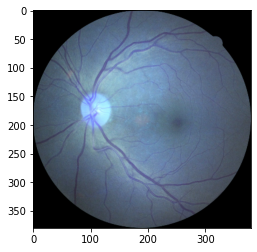

In [5]:
plt.imshow(train[0][0])
plt.show()

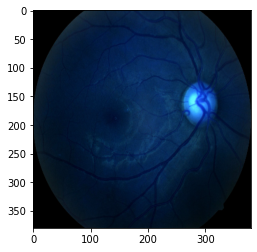

In [6]:
plt.imshow(val[0][0])
plt.show()

In [7]:
#load train images and labels in X_train and y_train

X_train = []
y_train = []

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)
    
X_train = np.array(X_train)
y_train = np.array(y_train)
y_train = np.expand_dims(y_train, axis=1)

print(X_train.shape)
print(y_train.shape)

(31209, 380, 380, 3)
(31209, 1)


In [8]:
X_val = []
y_val = []

for feature, label in val:
    X_val.append(feature)
    y_val.append(label)
    
X_val = np.array(X_val)
y_val = np.array(y_val)
y_val = np.expand_dims(y_val, axis=1)

print(X_val.shape)
print(y_val.shape)

(5125, 380, 380, 3)
(5125, 1)


In [9]:
# create the base pre-trained model
input_shape = [380,380]

base_model = EfficientNetB4 (input_shape = input_shape+[3], weights = 'imagenet', include_top = False)

x = base_model.output

x = GlobalAveragePooling2D()(x)

x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
x = Dropout(0.2)(x)

# and a logistic layer
out = Dense(5, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=out)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 380, 380, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 380, 380, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 381, 381, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [10]:
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

stopping = EarlyStopping(monitor='val_loss', patience=15)

model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [11]:
a =y_train.flatten()

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(a),
                                                 a)
print(class_weights)

[0.93370232 1.01       0.95265568 1.05578484 1.06153061]


C:\Users\asarkar.NATICK-NT\.conda\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4], y=[0 0 0 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [12]:
start_time = time.time()

callbacks = ModelCheckpoint('EfficientNetb4.h5', monitor='val_loss', save_best_only=True, mode = 'auto')

batch_size = 4

r = model.fit(X_train,y_train, validation_data=(X_val,y_val), 
                        batch_size=batch_size, epochs= 150, 
                        callbacks = [callbacks,lr_schedule,stopping])

Epoch 1/150
7803/7803 [==============================] - 1690s 217ms/step - loss: 1.5312 - accuracy: 0.3641 - val_loss: 0.9900 - val_accuracy: 0.7190loss: 2.99 - ETA: 26:02 - loss: 2.7573 - accuracy: 0 - ETA: 26: - ETA: 25:56 - loss: 2.7150 - accu -  - ETA: 25:50 - loss:  - ETA: 25:47 - l - ETA: 25:42  - E - ETA: 25:29 -  - ETA: 25:15 - los - ETA: 25:10 - loss: 2.5024 - ac - ETA: 25:08 - loss: 2.4950 - accuracy: 0.2 - ETA: 25:07 - loss: 2.4919 - accurac - ETA: 25:05 - loss: 2.4863 - accuracy: 0. - ETA: 25:05 - loss: 2.4844 - accuracy: 0.2 - ETA: 25:04 - loss: 2.4837 - accuracy: 0.29 - ETA: 25:04 - loss:  - E - ETA: 24:41 - loss: 2.4271 - accuracy: 0.297 - ETA: 24:40 - loss: 2.4264 -  - E - ETA: 24:29 - l - ETA: 24:23 - loss: 2.3822  - ETA: 24:19 - loss: 2.3728 - a - ETA: 24:16  - ETA: 24:09 - loss: 2.3504 - accuracy: 0.30 - ETA: 24:09 - loss: 2.3496 - accuracy: 0.30 - ETA: 24:09 -  - ETA: 23:53 - loss: 2.3148 - accuracy - ETA: 23:51 - loss: 2.3115 - accur - ETA: 23:49 - loss: 2.3063 - 

7803/7803 [==============================] - 1693s 217ms/step - loss: 0.8794 - accuracy: 0.6692 - val_loss: 0.7553 - val_accuracy: 0.7803 - ETA: 25:44 - loss: 0.9392 - accuracy: 0.62 - ETA: 25:43 - lo - ETA: 25:38 - loss:  - ETA: 25:32 - los - ETA: 25:26 - loss: 0.9371  - ETA: 25:22 - loss: 0.9355 - accuracy: 0.63 - ETA: 2 - ETA: 25:03 - loss: 0.9322 - acc - ETA: 25:01 - loss: 0.9289 - - ETA: 24:48 - loss: 0.92 - ETA: 24:43 - lo - ETA: 24:38 - loss: 0.92 - ETA: 24:33 - loss: - ETA: 24:28 - loss: 0 - ETA: 24:23 - loss - ETA: 24:17 - loss: 0.9324 - a - ETA: 1:07 - ETA: 58s - loss: 0.8807 - accuracy: - ETA: 57s - loss: 0.8806 - accuracy: 0 - ETA: 56s - loss: 0.8806 - accura - ETA: 35s - loss: 0.8799 - accuracy:  - ETA: 33s - -
Epoch 11/150
7803/7803 [==============================] - 1695s 217ms/step - loss: 0.8348 - accuracy: 0.6871 - val_loss: 0.6971 - val_accuracy: 0.8004:57 - loss - ETA: 25:42 - loss: 0.8429 - a - ETA: 25:39 - loss: 0 - ETA: 25:34 - loss: 0.843 - ETA: 25:30 - loss: 0.

7803/7803 [==============================] - 1669s 214ms/step - loss: 0.7684 - accuracy: 0.7145 - val_loss: 0.8598 - val_accuracy: 0.7461:20 - loss: 0.7492 - acc - ETA: 26:17 - loss: 0.7437 - accur - ETA: 2 - ETA: 25:58 - loss: 0.7487 - accuracy:  - ETA: 25:57 - loss: 0.7434 - acc - ETA: 25:55 - loss: 0.744 - ETA: 25:50 - loss: 0.7517 - accuracy: 0.72 - ETA: 25:50 - loss: 0.7525 - accuracy: - ETA: 25:48 - loss: 0.7489 - ETA: 25:45 - loss: 0.7475 - accuracy: - ETA: 25:43 - loss: 0.7493 - accuracy - ETA: 24:54 - loss: 0. - ETA: 24:49 - loss: 0.7746  - ETA: 24:44 - loss: 0.7744  - ETA: 24:41 - loss: 0.7776 - accuracy: 0 - ETA: 24:39 - loss: 0.7769 - accu - ETA: 24:37 - loss: 0.7750 - accuracy - ETA: 24:35 - loss: 0.7719 - accuracy: 0.70 - ETA: 24:34 - loss: 0.7712 - acc - ETA: 24:31 - loss: 0.7705 - accuracy: 0.7 - ETA: 24:31 - l - ETA: 24:24 - loss: 0.7675 -  - ETA: - ETA: 24:12 - loss: 0.7661 - - ETA: 24:09 - loss: 0.7623 - accuracy: 0.712  - ETA: 23:39 - los - ETA: 23:33 - loss: 0.7518

7803/7803 [==============================] - 1741s 223ms/step - loss: 0.7389 - accuracy: 0.7291 - val_loss: 0.7379 - val_accuracy: 0.77540 - accuracy: 0.73 - ETA: 21:20 - loss: 0.7233 - accuracy: 0.7 - ETA: 21:19 - loss: 0.7232 - accuracy: 0.7 - ETA: 21:19 - lo - ETA: 21:11 - loss: 0.725 - ETA: 21:06 - loss: 0.7259 - accuracy: 0.733 - ETA: 21:06 - loss: 0.7257 - - ETA: 21:02 - loss: 0.7265 - - ETA: 20:57 - loss: 0.7259 - accuracy: 0. - ETA: 20:56 - loss: 0.7263 - accu - ETA: 20:53 - loss: 0.7262 - accurac - ETA: 20:5 - ETA: 20:42 - loss - ETA: 20:34 - loss: 0.7306 -  - ETA: 20:30 - loss: 0 - ETA: 20:24 - loss: 0.7294 - accuracy: 0. - ETA: 20:23 - loss: 0.7288 - a - ETA: 19:56 - loss: 0 - ETA: 19:50 - loss: 0.7278 - acc - ETA: 19:46 - loss: 0.7286 - accura - ETA: 19:44 - loss: 0.7291 - accuracy: 0 -  - ETA: 19:32 - loss: 0.7287 -  - ETA: 19:28 - loss: 0.7283 - accur - ETA: 19:25 - loss: 0. - ETA: 19:07 - loss: 0.7 - ETA: 19:02 - loss:  - ETA: 18:55 - loss: 0.7304 - accur - ET - ETA - ET

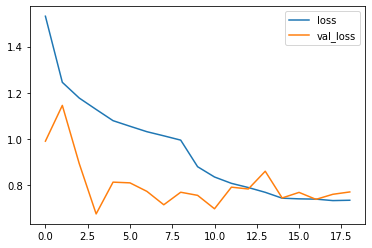

In [13]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

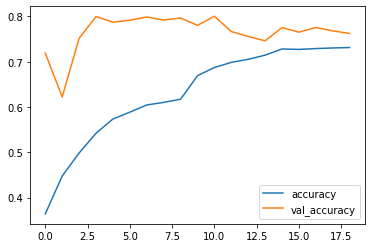

In [14]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [15]:
model2 = tf.keras.models.load_model('EfficientNetb4.h5')

In [16]:
P= model2.predict(X_val, steps=len(X_val)).argmax(axis=1)

([<matplotlib.axis.YTick at 0x202d789b748>,
 [Text(0, 0, 'Level_0'),
  Text(0, 1, 'Level_1'),
  Text(0, 2, 'Level_2'),
  Text(0, 3, 'level_3'),
  Text(0, 4, 'Level_4')])

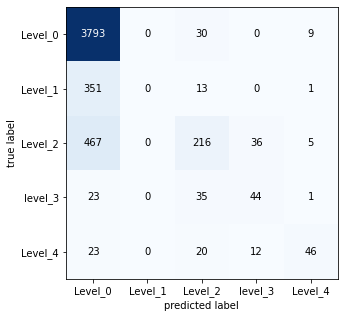

In [17]:
matrix = confusion_matrix (y_val, P)
plot_confusion_matrix(matrix, figsize=(5,5))
plt.xticks(range(5), ['Level_0','Level_1','Level_2','level_3','Level_4'], fontsize=10)
plt.yticks(range(5), ['Level_0','Level_1','Level_2','level_3','Level_4'], fontsize=10)

In [9]:
model2 = tf.keras.models.load_model('EfficientNetb4.h5')

In [10]:
model2.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [11]:
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

stopping = EarlyStopping(monitor='val_loss', patience=15)

In [12]:
callbacks = ModelCheckpoint('EfficientNetb4_2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode = 'auto')

batch_size = 4

r = model2.fit(X_train,y_train, validation_data=(X_val,y_val), 
                        batch_size=batch_size, epochs= 150, 
                        callbacks = [callbacks,lr_schedule,stopping])

Epoch 1/150
7803/7803 [==============================] - ETA: 0s - loss: 1.0818 - accuracy: 0.5751   - ETA: 24:44 - loss: 1.2280 - a - ETA: 25:44 - loss: 1.2393 - accuracy: 0. - ETA: 25:48 - loss: 1.2325 - accur - ETA: 26:15 - loss: 1.1588 - accuracy: 0. - ETA: 26:14 - loss: 1.1664  - ETA: 26:14 - loss: 1.1616 - accuracy: 0 - ETA: 26:14 - los - ETA: 26:09 - loss: 1 - ETA: 26:06 - ETA: 26:01 - loss: 1.1323 - accuracy: 0.5 - ETA: 26:00 - loss: 1.1315 - ETA: 25:58 - loss: 1.1264 - acc - ETA: 25:56 - loss: 1.1182 - ETA: 25 - ET - ETA: 25:11 - loss: 1.1197 - accuracy: - ETA: 25:10 - loss: 1.1156 - accura - ETA: 25:07 - loss: 1.1151 - accuracy - ETA: 25:06 - loss: 1.1140 - accuracy:  - ETA: 25:05 - loss: 1 - ETA: 25:00 - loss: 1.1164 - accuracy - ETA: 24:58 - loss: 1.1135 - accuracy: 0. - ETA: 24:57 - los - ETA: 24:32 - - ETA: 24:25 - loss: 1.1019 - accuracy: 0.56 - ETA: 24:25 - loss: 1.1018 - ETA: 24:21 - loss - ETA: 24:15 - loss: - ETA: 24:10 - loss: 1.0978 -  - ETA: 24:07 - loss: 1.0959 -

7803/7803 [==============================] - ETA: 0s - loss: 0.9903 - accuracy: 0.6249   - ETA: 24:58 - loss: 0.9571 - accuracy: 0. - ETA: 25:18 - loss: 0.967 - ETA: 28:29 - loss:  - ETA: 28:08 - loss: 0.9788 - accuracy: 0.620 - ETA: 28:07 - loss: 0.9758 - accuracy: 0.6 - ETA: 28:05 - loss: 0.9754 - accuracy: 0.622 - ETA: 28:04 - loss: 0.9783 - acc - ETA: 27:56 - loss: 0.9710 - accuracy: 0.62 - ETA: 27:55 - loss: 0.9671 - accur - ETA: 27:48 - loss: 0.9724 - accuracy:  - ETA: 27:44 - l - ETA: 27:29 - lo - ETA: 27:14 - loss: 0.9815 -  - ETA: 27:07 - loss: 0 - ETA: 26:58 - loss: 0. - ETA: 26:48 - - ETA: 26:37 - loss: 0.9739 - accuracy:  - ETA: 26:35 - loss: 0.9756 - accuracy:  - ETA: 26:33 - loss: 0. - ETA: 26:25 - loss: 0.9677 -  - ETA: 26:20 - loss: 0.9696 - accuracy: 0.62 - ETA: 26:20 - loss: 0.9708 - accuracy: 0.6 - ETA: 26:19 - loss: 0.9713 - accuracy:  - ETA: 26:16 - loss: 0.9695 - a - ETA: 26:12 - loss: 0.9689 - accuracy: 0. - ETA: 26:10 - lo  - ETA: 25:36 - loss: 0.9779 - acc - ET

7803/7803 [==============================] - 1681s 215ms/step - loss: 0.9689 - accuracy: 0.6325 - val_loss: 0.7444 - val_accuracy: 0.8016
Epoch 7/150
6224/7803 [======================>.......] - ETA: 5:29 - loss: 0.9599 - accuracy: 0.6370 - ETA: 25:58 - l - ETA: 26:21 - lo - ETA: 26:31 - loss: 0.9 - ETA: 26:2 - ETA: 26:22 - lo - ETA: 26:09 -  - ETA: 26:03 - loss: 0.9703 - accuracy - ETA: 26:01 - loss: 0.9683 - ETA: 25:58 - loss: 0.9622 - accuracy: 0 - ETA: 25:57 - loss: 0.9596 - accuracy: 0. - ETA: 25:56 - loss: 0.9549 - ETA:  - E - ETA: 25:37 - loss: 0.9613 - accuracy: 0.63 - ETA: 25:37 - loss: 0.9610 - accuracy:  - ETA: 25:36 - loss: 0.9621 - accuracy: 0 - ETA: 25:35 - loss: 0.9617 - accur - ETA: 25:23 - loss: 0.9679 - accura - ETA: 25:21 - loss - ETA: 25:15 - loss: 0.9661 - accura - ETA: 25:13 - loss: 0.9673 - a - ETA: 25:10 - loss: 0.9715 - accuracy: 0.6 - ETA: 25:09 - loss: 0.9713 - accuracy - ETA: 25:08 - loss: 0.9725 - accuracy: 0.6 - ETA: 25:07 - loss: 0.9736 - accur - ETA: 25:

5125/7803 [==================>...........] - ETA: 9:19 - loss: 0.9408 - accuracy: 0.6497 A: 12:51 - loss: 1.1604 - ac - ETA: 25:28 - loss: 1.3305 - accuracy: 0. - ETA - ETA: 26:28 - - ETA: 26:35 - loss: 0.9892 - accuracy: - ETA: 26:34 - loss: 1.0054 -  - ETA: 26:31 - loss: 0.9873 - accuracy: 0. - ETA: 26:31 - los - E - ETA: 26:13 - los - ETA: 26:08 - loss: 0.9781 - - ETA: 26:04 - loss: 0.9683 - accuracy: 0 - ETA: 26:03 - loss: 0.9669 - ac - ETA: 26:01 - loss: 0.9631 - accuracy: 0.647 - ETA: 2 - ETA: 25:54 - loss: 0.9764 - accuracy: 0.6 - ETA: 25:53 - loss: 0.9 - ETA: 25:49 - loss: 0.9669 - accur - ETA: 25:46 - loss: 0.9753 - accuracy:  - ETA: 25:45 - loss: 0.9734 - ETA: 25:41 - loss: 0 - ETA: 25:36 - loss: 0.9701 - accuracy: 0.65 - ETA: 25:36 - loss: 0.9707 - accurac - ETA: 25:34 - loss: 0.9668 - accur - ETA: 25:32 - loss - ETA: 25:17 - loss: 0.9687 - accuracy: 0.65 - ETA: 25:17 - loss: 0.9676 - accurac - ETA: 25:15 - loss: 0.9679 - accuracy: - ETA: 25:13 - loss: 0.9623 - accuracy: - E

7803/7803 [==============================] - ETA: 0s - loss: 0.9402 - accuracy: 0.6476   ETA: 7:19 - - ETA: 7:16 - loss: 0.9391 -  - ETA: 7: - ETA:  - ETA: 7:06 - loss: 0.9397 - accuracy:  - ETA: 7:06 - loss: 0.9396 - accuracy:  - ETA: 7:05 - loss: 0.9395 - accuracy - ETA: 6:59 - loss: 0.9385 - accuracy: 0.65 - ETA: 6:59 - loss: 0.9385 - accuracy: 0. - ETA: 6:59 - loss: 0.9385 - accura - ETA: 6:58 - loss: 0.9 - E - ETA: 6:51 - loss: 0.9385 - accuracy:  - ETA: 6:50 - loss: 0.9387 - ac - ETA: 6:49 - loss: 0.9387 - accuracy:  - ETA: 6:48 - loss: 0.9389 - accuracy: 0. - ETA: 6:48 - loss: 0.9388  - ETA - ETA: 6:37 - loss: 0.9 - ETA: 6:35 - loss: 0.9398 - ac - ETA: 6:33 - loss: 0 - ETA: 6:11 - ETA:  - - ETA: 5:35 - loss: 0.9388  - ETA: 5:33 - loss: 0.9387 - accura - ETA: 5:32 - loss: 0.9 - ETA: 5:30 - loss: 0 - ETA: 5:27 - loss: 0.938 - ETA - E - ETA: 5:02 - loss: 0.9 - ETA: 4: - ETA: 3:49 - loss: 0.9377 - accu - ETA: 3:48 - - ETA: 3:44 - loss: 0.937 - ETA - ETA: 1:09 - ETA: 1:06 - loss: 0.9

7803/7803 [==============================] - ETA: 0s - loss: 0.9094 - accuracy: 0.6625   - ETA: 25:01 - loss: 0.8905 - accura - ETA: 26:07 - loss: 0.9197 - accurac - ETA: 26:33 - loss: 0.9558 - accuracy: 0 - ETA: 26:37 - loss: 0.9254 - accuracy: 0. - ETA: 26:39 - loss - ETA: 27:05 - loss:  - ETA: 26:57 - l - ETA: 26:51 - loss: 0.8432 - accuracy - ETA: 26:49 - loss: 0.8513 - accu - ETA: 26:48 - loss: 0.8472 - accuracy: 0 - ETA: 26:47 - loss: 0.8527 -  - ETA: 26:16 - loss: 0.9021 - ETA: 26:12 - loss: 0.9052 - accuracy:  - ETA: 26:10 - loss: 0.9040 - accuracy: 0.67 - ETA: 26:09 - loss: 0.9049 - accuracy: 0. - ETA: 26:09 - loss: 0.9034 - a - ETA: 26:00 - loss: 0.8907 - accuracy - ETA: 25:59 - loss:  - ETA: 25:43 - loss: 0.9001 - accurac - ETA: 25:40 - loss: 0.9023 - accura - ETA:  - ETA: 25:29 - loss: 0.9116 - accuracy:  - ETA: 25:27 - loss: 0.9113 - accu - E - ETA: 25:14 - l - ETA: 25:07 - - ETA: 25:0 - ETA: 2 - E - ETA: 24:25 - loss: 0.9028 - - ETA: 24:21 - loss:  - ETA: 24:16 - loss: 0.

7803/7803 [==============================] - ETA: 0s - loss: 0.6598 - accuracy: 0.7678   - ET - ETA: 25:19 - loss: - ETA: 25:14 - ETA: 23:18 - loss: 0.6708 - accuracy:  - ETA: 23:16 - loss: 0.6703 - a - ETA: 22:53 - loss: 0.6683  - ETA: 22:50 - loss: 0.6 - ETA: 22:45 - loss: - ETA: 22:19 - loss: 0.6675 - accur - ETA: 22:1 - ETA: 22:10 - los - ETA: 22:04 - loss: 0.6676 - accuracy: 0.76 - ETA: 22:03 - loss: 0.6678 - accuracy: 0. - ETA: 22:03 - loss: 0.6671 - accuracy: 0 - ETA: 22:02 - loss: 0.6669 - accuracy: 0.76 - ETA: 22:01 - loss: 0.6669 - accu - ETA: 21 - ETA: 20:02 - loss: 0. - ETA - ETA: 19:48 - loss: 0. -  - ETA: 19:34 - los - ETA: 19:31 - ETA: 1 - ETA: 19:15  - ETA: 19:08 - loss: 0.6723 - accuracy: 0.76 - ETA: 19:07 - loss: 0.6720 - accuracy - ETA: 19:06 - los
Epoch 00019: val_loss did not improve from 0.70862
7803/7803 [==============================] - 1694s 217ms/step - loss: 0.6598 - accuracy: 0.7678 - val_loss: 0.7836 - val_accuracy: 0.7688
Epoch 20/150
7803/7803 [=========

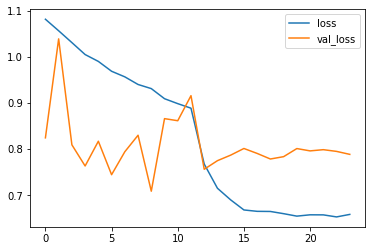

In [13]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

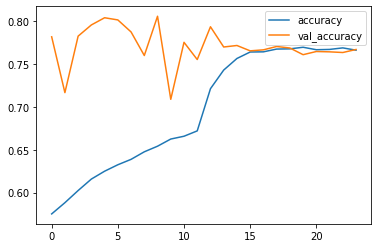

In [14]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [15]:
final_model = tf.keras.models.load_model('EfficientNetb4_2.h5')

In [16]:
P2 = final_model.predict(X_val, batch_size=4).argmax(axis=1)

([<matplotlib.axis.YTick at 0x20b58909cc8>,
 [Text(0, 0, 'Level_0'),
  Text(0, 1, 'Level_1'),
  Text(0, 2, 'Level_2'),
  Text(0, 3, 'level_3'),
  Text(0, 4, 'Level_4')])

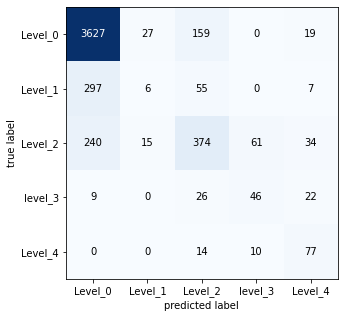

In [17]:
matrix = confusion_matrix (y_val, P2)
plot_confusion_matrix(matrix, figsize=(5,5))
plt.xticks(range(5), ['Level_0','Level_1','Level_2','level_3','Level_4'], fontsize=10)
plt.yticks(range(5), ['Level_0','Level_1','Level_2','level_3','Level_4'], fontsize=10)

In [19]:
def perf_measure(y_holdout, P):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(P)): 
        if y_holdout[i]==P[i]==1:
           TP += 1
        if y_holdout[i]==1 and y_holdout[i]!=P[i]:
           FP += 1
        if y_holdout[i]==P[i]==0:
           TN += 1
        if y_holdout[i]==0 and y_holdout[i]!=P[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [19]:
tp, fp, tn ,fn = perf_measure(y_val,P2)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F-Score is {:.2f}".format(f_score))

Recall of the model is 0.03
Precision of the model is 0.02
F-Score is 0.02


In [10]:
model3 = tf.keras.models.load_model('EfficientNetb4_2.h5')

In [12]:
from tensorflow.keras import layers

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-15:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model3)

In [13]:
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4)

stopping = EarlyStopping(monitor='val_loss', patience=30)

In [14]:
callbacks = ModelCheckpoint('EfficientNetb4_3.h5', monitor='val_loss', verbose=1, save_best_only=True, mode = 'auto')

batch_size = 4

r = model3.fit(X_train,y_train, validation_data=(X_val,y_val), 
                        batch_size=batch_size, epochs= 150, 
                        callbacks = [callbacks,lr_schedule,stopping])

Epoch 1/150
   2/7803 [..............................] - ETA: 13:02 - loss: 0.7477 - accuracy: 0.7500WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0533s vs `on_train_batch_end` time: 0.1472s). Check your callbacks.


6529/7803 [========================>.....] - ETA: 4:26 - loss: 0.8238 - accuracy: 0.6994 - ETA: 25:55 - - ETA: 25:22 -  - ETA: 25:16 - loss: 0.8844 - accuracy: 0 - ETA: - ETA: 25:07 - loss: 0.8853 - accuracy: 0 - ETA: 24:49 - loss: 0.8768 - acc - ETA: 24:47 - loss: 0.8765 - ETA: 24:43 - loss: 0.8722 - accuracy: - ETA: 24:41 - loss: 0.8727 - a - ETA: 24:38 - loss: 0. - ETA: 24:33 - loss: 0.8688 - a - ETA: 24:30 - loss: 0.8669 - accuracy: 0.6 - ET - ETA: 24:12 - lo - ETA: 24:06 - loss: 0.8688 - accuracy: 0.678 - ETA: 24:06 - ETA: 23:49 - loss: 0.8679 - accur - ETA: 23:47 - loss: 0.8682  - ETA: 23:43 - loss: 0.869 - ETA - ETA: 23:31 - l - ETA: 22:46 - loss: 0.8651 - ETA: 22:42 - loss - ETA: 22:27 - - ETA: 22:11 - loss: - ETA: 22:06 - loss: 0.8635 - accuracy - ETA: 22:04 - loss: 0 - ETA: 2 - ETA: 21:42 - loss: 0.8665 - accuracy:  - ETA: 21:40 - loss: 0.8665 - accura - ETA: 21:38 - loss: 0.8643 - accuracy: 0.68 - ETA: 21:38 - loss: 0.8643 - accuracy: 0.682 - ETA: 21:38 - loss: 0.8643 - accu

7803/7803 [==============================] - ETA: 0s - loss: 0.8175 - accuracy: 0.7008   ETA: 3:57 - l - ETA: 3:54 - los - ETA: 3:51 - loss: 0.8227 -  - ETA: 3:49 - loss: 0.8224 - accuracy: 0. - ETA: 3:49 - ETA: 3:45 - loss: 0.8227 - accu - ETA: 3:39 - l - ETA: 3:22 - l - ETA: 3:19 - loss: 0.8226 - accu - ETA - ETA: 2:30 - los - - ETA: 1:58 - loss: 0.820 - ETA: 1:56 - loss: 0.8206  - ETA: 1:54 - loss: 0.8207 -  - ETA: 1:53 - loss: 0.8208 - accuracy: 0. - ETA: 1:48 - loss: 0.8208 - accuracy:  - ETA: 1:47 - los - ETA: 1:44 - loss: 0.8204  - ETA: 1:32 - loss: 0.8201 - accura - ETA: 1:31 - loss: 0.8201 - accuracy: 0. - ETA: 1:31 - loss: 0.8201 - ac - ETA: 1:30 - los - ETA: 1:27 - - ETA: 1:23 - loss: 0.8197 - accuracy: 0.69 -  - ETA: 59s - loss: 0.81 - ETA: 36s - loss: 0.8188 - accuracy: 0.70 - ETA: 36s - loss: 0.8189 - accuracy: 0.7 - ETA: 35s - loss: 0.8 - ETA: 30s - loss: 0.8185 - acc - ETA: 28s - loss: 0.8182 - accu - ETA: 25s - loss: 0.8180 - accuracy: 0.7 - ETA: 25s - loss: 0.8181 - a

3981/7803 [==============>...............] - ETA: 13:14 - loss: 0.7845 - accuracy: 0.7163- ETA: 25:50 - loss: 0.8394 - accuracy: 0. - ETA: 25:57 - loss: 0.8772 - accuracy: 0. - ETA: 26:03 -  - ETA: 26:25 - loss: 0.8601 - acc - ETA: 26:23 - loss: 0.8403 - accuracy: 0. - ETA: 26:22 - ETA: 26:20 - loss: 0.8463 - accu - ETA: 26:17 - loss: 0.8518 - acc - ETA: 26:14 - loss: 0.8553 - accuracy: 0.6 - ETA: 26:14 - loss: 0. - ETA: 26:10 - loss: 0.8744 - accuracy - ETA: 26:0 - ETA: 26 - ETA: 25:55 - loss: 0.8503 - accura - ETA: 25:54 - loss: 0.8555 - accuracy: 0. - ETA: 25:53 - loss: 0.8515 - accuracy: 0 - ETA: 25:52 - loss: 0.8475 - acc - ETA: 25:49 - loss: 0.8536 - accuracy: - ETA: 25:47 - loss: 0.8511 - accuracy -  - ETA: 25:29 - loss: 0. - ETA: 25:24 - loss: 0.8367 - ac - ETA: 25:21 - loss: 0.8353 - accuracy: 0.691 - ETA: 25:21 - lo - ETA: 25:15 - loss: 0.8377 - accuracy: 0 - ETA: 25:14 - los - ETA: 25:09 - - ETA: 25:02 - loss: 0.8387 - accuracy: 0. - ETA: 25:01 - ETA: 24:54 - loss: 0.8364 - 

7803/7803 [==============================] - ETA: 0s - loss: 0.7730 - accuracy: 0.7177   - ETA: 13:13 - loss: 0.7848 - ETA: 13:10 - loss: 0.78 - ETA: 13:05 - loss: 0.7850 - accu - ETA: 13:03 - loss: 0.7847 - accuracy: 0.71 - ETA: 13:02 - loss: 0.7848 - accuracy - ETA: 13:01 - loss: 0.7845 - accuracy: 0.716 - ETA: 13:00 - loss: 0.7848 - accur - ETA: 12:58 - loss: 0.7848 - accuracy:  - ETA: 12:57 - loss: 0.7849 - accura - ETA: 12:55 - loss: 0 - ETA: 12:50 - loss: 0.7850 - accuracy: 0.715 - ETA: 12:50 - loss: 0.7852 - accuracy - ETA: 12:48 - loss: 0.7848 - accura - ETA: 12:46 - loss: 0.7849 - accurac - ETA: 12:44 - loss: 0.7851 - accura - ETA: 12:42 - loss: 0.7845 - accuracy: - ETA: 12:40 - loss: 0.7847 - acc - ETA: 12:38 - loss: 0.7853 - ETA: 12:34 - loss: 0.7854 -  - ETA: 12:21 - loss: 0.7854 - accu - ETA: 12:18 - loss: 0.7850 - - ETA: 12:15 - loss: 0.7841 - - ETA: 12:11 - loss: 0.7837 - accuracy: 0 - ETA: 12:10 - loss: 0.7837 - accura - ETA: 12:08 - loss: 0.7838 - accuracy: 0.71 - ETA:

7803/7803 [==============================] - ETA: 0s - loss: 0.7425 - accuracy: 0.73164  - ETA: 21:37 - loss: 0.5589 - accuracy:  - ETA: 24:33 - loss: 0.6 - ETA: 26:03 - loss: 0.7339 - accuracy: 0. - ETA:  - ETA: 26:25 - loss: 0.7711 - accuracy: 0.700 - - ETA: 26:25 - loss: 0.7183 - accur - ETA: 26:23 - loss: 0.7322 - accur - ETA: 26:22 - loss: 0.7227 - - ETA: 26:20 - loss: 0.7309 - accuracy: 0.729 - ETA: 26:19 - loss: 0.7359 - accuracy - ETA: 26:18 - loss: 0. - ETA: 26:13 - loss: 0.7187 - accuracy: 0.73 - ETA: 26:13 - loss: 0.7187  - ETA: 26:08 - loss: 0.7223 - accur - ETA: 26:06 - loss: 0.7230 - accuracy:  - ETA: 26:05 - loss: - ETA: 26:01 - loss: 0.7199 - acc - ETA: 25:58 - loss: 0.7161 - accuracy: 0.7 - ETA: 25:58 - loss: 0.7143 - accurac - ETA: 25:56 - ETA: 25:23 - loss: 0.7382 - accuracy: 0. - ETA: 25:22 - loss: 0.7378 - accuracy: 0.7 - ETA: 25:21 - loss: 0.7379 - ac - ETA: 25:18 - loss: 0.7387 - accuracy: 0. - ETA: 25:17 - loss: 0.7404 - accuracy: 0.7 - ETA: 25: - ETA: 25:00 - l

4022/7803 [==============>...............] - ETA: 13:08 - loss: 0.7212 - accuracy: 0.7419- ETA: 26:32 - loss: 0.7075 - acc - ETA: 26:32 - loss: 0.6950 - accuracy: 0.75 - ETA: 26:32 - loss: 0.6876  - ETA: 26:28 - loss: 0.7128 - accu - ETA: 26:26 - loss: 0.7186 - accuracy: 0.7 - ETA: 26:25 - loss: 0.7268 - accuracy: 0. - ETA: 26:25 - loss: 0.7309 - accuracy:  - ETA: 26:25 - loss: 0. - ETA: 26:20 - lo - ETA: 26:14 - loss: 0.6975 - accuracy:  - ETA: 26:13 - loss: 0.6967 -  - ETA: 26:01 - loss: 0.7235 - accuracy - ETA: 25:59 - loss: 0.7255 - acc - ETA: 25:57 - loss: 0.7266 - ac - ETA: 25:54 - loss: 0.7363 -  - ETA: - ETA: 25:43 - loss: 0.7396 - accura - ETA: 2 - ETA: 25:14 - loss: 0.7270 - acc - ETA: 25:12 - loss: 0.7224 - accuracy: 0.744 - ETA: 25:12 - loss: - ETA: 25:06 - loss: 0.7131 - accuracy: 0. - ETA: 25:05 - loss: 0.71 - ETA: 25: - ETA: 2 - ETA: 24:46 - loss: 0.7084 - ac - ETA: 24:43 - loss: 0.7069 -  - ETA: 24:40 - loss: 0 - ETA: 24:35 - los - ETA: 24:30 - loss: 0.703 - ETA: 24:25 

7803/7803 [==============================] - ETA: 0s - loss: 0.7168 - accuracy: 0.7419   - ETA: 13:06 - loss: 0.7212 - ac - ETA: 13:03 - loss: 0.7211 - accurac - ETA: 13:01 - loss: 0 - ETA: 12:56 - loss: 0.7217 - accu - ETA: 12:54 - loss:  - ETA: 12:48 - loss: 0.7220 - accurac - ETA: 12:46 - loss: 0.7219 - accura - ETA:  - ETA: 12:36 - loss - ETA: 12:31 - loss: 0.7204 - ac - ETA: 12:28 - ETA: 12:21 - loss: 0.7195 -  - ETA: 12:17 - loss: 0.7192 - accura - ETA: 12:15 - loss: 0.7191 - accu - ETA: 12:13 - loss: 0.7188 - accuracy: 0.7 - ETA: 12:12 - lo - - ETA: 11:57 - loss: 0.720 - ETA: 11:52 - loss: 0.7208 - accuracy: 0.7 - ETA: 11:52 - loss: 0.7207 - accuracy: 0. - ETA: 11:51 - loss: 0.7205 - accuracy: - ETA: 11:50 - loss: 0.7208 - accuracy: 0. - ETA: 11:49 - loss: 0.7209 - accur - ETA: 11:46 - loss: 0.7207 - accuracy:  - ETA: 11:45 - loss: 0.7209 - accur - ETA: 1 - ETA: 11:15 - loss: 0.7211 - accuracy - ETA: 11:14 - loss: 0.7210 - accuracy: 0. - ETA: 11:13 - loss: 0.7208 - accuracy: 0.7

3784/7803 [=============>................] - ETA: 13:59 - loss: 0.7079 - accuracy: 0.7431- ETA: 20:37 - loss: 0.9725 - accuracy: 0 - ETA: 24:17 - loss: 0.9508 - accurac - ETA: 25: - ETA: 26:27 - ETA: 26:36 - loss: 0.7648 - ac - ETA: 2 - ET - ETA: 26:22 - loss: 0.7117 -  - ETA: 26:20 - loss: 0.7101 - acc - ETA: 26:17 - loss: 0.7031 - accuracy: 0.7 - ETA: 26:16 - loss: 0.7121 - a - ETA: 26:14 - loss: 0.7053 - accuracy: 0.741 - ETA: 26:13 - loss: - ETA: 26:01 - loss: 0.7220 - accuracy - ETA: 25:59 - loss: 0.7240 - accurac - ETA: 25:58 - loss: 0.7255 - - ETA: 25:55 - loss: 0.7303 -  - ETA: 25:52 - loss: 0.7279 - accuracy: 0. - ETA: 25:51 - loss: 0.7242 - accuracy: 0.736 - ET - ETA: 25:43 - loss: 0.7262 - accur - ETA: 25:41 - loss: 0.7225 - accuracy: 0.73 - ETA: 25:41 - loss: 0.7205 - accuracy: 0.7 - ETA: 25:40 - loss: 0.7210 - accur - ETA: 25:37 - loss: 0.7199 - accuracy: 0. - ETA: 25:37 - loss: 0.7190 - accuracy: 0. - ETA: 25:36 - loss: 0.7204 - accuracy: 0.7 - ETA: 25:35 - loss: 0.7207 -

7803/7803 [==============================] - ETA: 0s - loss: 0.7067 - accuracy: 0.7466   - ETA: 13:56 - loss: 0.7082 - accurac - ETA: 13:54 - loss: 0.7084 - accuracy: 0.743 - ETA: 13:54 - loss: 0.7084 - accurac - ETA: 13:52 - loss: 0.7086 - accuracy: 0.74 - ETA: 13:52 - loss: 0.7084 - accuracy: 0 - ETA: 13:51 - loss: 0.7084 - accuracy - ETA: 13:49 - loss: 0.7 - ETA: 13:45 -  - ETA: 13:38 - loss: 0.7089 - accurac - ETA: 13:36 - loss:  - ETA: 13:31 - - ETA: 13:24 - loss: 0. - ETA: 13:20 - l - ETA: 13:13 - loss: 0.7071 - accuracy: - ETA: 13:12 - loss: 0.7065 - accuracy: 0.7 - ETA: 13:11 - loss: 0.7066 - accurac - ETA: 13:09 - loss: 0.7062 - accuracy: 0. - ETA: 13:09 - loss: 0.7059 - accuracy: 0.74 - ETA: 13:08 - loss: 0.7060  - ETA: 13:04 - loss: 0.7063 -  - ETA: 13:01 - loss: 0.7070 - accu - ETA: 12:59 - loss: - ET - ETA: 12:44 - loss: 0.7071 - accu - ETA: 12:42 - loss: 0.707 - ETA: 12:38 - lo - ETA: 12:32 - loss: - ETA: 12:26 - loss: 0.7066 - accuracy:  - ETA: 12:25 - loss: 0.7064 - acc

7803/7803 [==============================] - ETA: 0s - loss: 0.6836 - accuracy: 0.7562   - ETA: 26:07 - loss: 0.6653 - accuracy - ETA: 26:05 - loss: 0.6629 - accura - ETA: - ETA: 25:34 - loss: 0.6803 - accur - ETA: 25:32 -  - ETA: 25:25 - loss: 0.6761 - accuracy:  - ETA: 24:55 - loss: 0.6925 - accura - ETA: 24:53 - loss: 0.6912 - accuracy:  - ETA - ETA: 24:42 - loss: 0.6911 - accu - ETA: 24:40 - loss: 0.6896 - accur - ETA: 24:37 - loss: 0.690 - ETA: 24:33 - loss: 0.6937 - accu - ETA: 24:31 - loss: 0. - ETA: 24:26 - - ETA: 24:00 - loss: 0.6962 - accuracy: 0.7 - ETA: 23:59 - loss: 0.6954 - accuracy: 0.75 - ETA: 23:59 - loss: 0.6950 - accuracy: 0.7 - ETA: 23:58 -  - ETA: 23:13 - loss: 0.694 - ETA: 23:09 - loss: 0.6932 - accuracy: 0. - ETA: 23:08 - los - ETA: 23:0 - ETA: 22:55 - loss: 0.6921 - accuracy: 0.75 - ETA: 22:55  - ETA: 22:48 - loss: 0.6913 - accuracy: 0.75 - ETA: 22:47 - loss: 0.6911 - accuracy - ETA: 22:46 - loss: 0.6920  - ETA:  - ETA: 59s - loss: 0 - ETA: 54s - loss: 0.6842 - 

6462/7803 [=======================>......] - ETA: 4:42 - loss: 0.6698 - accuracy: 0.7616 - ETA: 20:37 - loss: 0.4006 - accuracy:  - ETA: 24:37 - loss: 0.5684 - accu - ETA: 26:11 - loss: 0.5923 - accura - ETA: 26:26 - loss: 0.5866 - accuracy:  - ETA: 26:32 - loss: 0.6159 - ETA: 26:45 - lo - ETA: 26:43 - loss: 0.6600 -  - ETA: - ETA: 26 - ETA: 26:34 - loss: 0.6998 - accuracy: 0. - ETA: 26:33 - loss: 0.6974 - accurac - ETA: 26:24 - loss: 0.6929 - accuracy: - ETA: 26:23 - loss: 0.6952 - accura - ETA: 2 - ETA - ETA: 25:48 - loss: 0.6678 - accu - ETA: 25: - ETA: 25: - ETA: 25:20 - loss: 0.6687 - accur - ETA: 25:18 - loss - ETA: 25:12 - lo - ETA: 24:38 - loss: 0.673 - ETA: 24:33 - loss: 0.671 - ETA: 24:29 - loss: 0.6724 - ETA: 24:26 - loss: 0.6754 - accuracy: 0.75 - ETA: 24:25  - ETA: 24:18 - loss: 0.6755 - accuracy: - ETA: 24:17 - loss: 0.6754 - accuracy: 0. - ETA: 24:16 - loss: 0.6750 - accuracy: 0.7 - ETA: 24:15 - loss: 0.6750 - accuracy: 0.75 - ETA: 24:15 - loss: 0.6758 - accuracy: 0 - ET

7803/7803 [==============================] - ETA: 0s - loss: 0.6711 - accuracy: 0.7601   ETA: 4:38 - los - ETA: 4:35 - loss: 0.6704 - accura - ETA: 4:34 - loss: 0.6704  - ETA: 4:32 - loss: 0.6701 - ac - ETA: 4:30 - loss: 0.6703  - ETA: 4:28 - loss: 0.6702 - accuracy - ETA: 4:27 - loss: 0.6702 - accuracy: 0. - ETA: 4:27 - loss: 0.6701 - accuracy - ETA: 4:26 - loss: 0.6 - ETA: 4:24 - loss: 0.6700 - accuracy: 0. - ETA: 4:23 - loss: 0.6700 -  - ETA: 4:22 - loss: 0.6700 - accuracy: 0. - ETA: 4:21 - loss: 0.6700 -  - ETA:  - ETA: 4: - ETA: 4:07 - E - ETA: 3:49 - loss: 0.6708  - ETA: 3: - ETA: 3:43 - loss: 0.6704 -  - ETA: 3:42 - loss: 0.6703 -  - ETA: 3:40 - - ETA: 3:37 - loss: 0.6700 - accuracy: 0. - ETA: 3:36 - loss: 0.6699 - accuracy - ETA: 3:35 - loss: 0.6701  - ETA: 3:33 - l - ETA: 3:30 - loss: 0.6702 - accuracy:  - ETA: 3:30 - l - ETA: 3:27 - los - ETA: 3:24 - ETA: 3:20 - loss: 0.6706 - accuracy: 0.76 - ETA: 3:20 - loss: 0.6706 - accuracy: 0. - ETA: 3:19 - - ETA: 3:16 - loss: 0.6711 - 

2855/7803 [=========>....................] - ETA: 17:07 - loss: 0.6708 - accuracy: 0.7651- ETA: 26:41 - loss: 0.6677 - accu - ETA:  - ETA: 26:27 - loss: 0.6728 - ac - ETA: 26:22 - loss: - ETA: 26:02 - loss: 0.6759 - ac - ETA: 25:58 - loss: 0.6764 - accuracy: 0.7 - ETA: 25:57 - loss: 0.6755 - accuracy: 0.76 - ETA: 25:57 - loss: 0.6771 - accuracy:  - ETA: 25:55 - loss: 0.6754 - accuracy: 0.77 - ETA: 25:55 - loss: 0.6736 - accuracy: 0.771 - ETA: 25:54 - loss - ETA: 25:47 - loss: 0.66  - ETA: 25:32 - loss: 0.6802 - accuracy: 0 - ETA: 25:30 - loss: 0.6826 - accur - ETA: 25:28 - loss: 0.6792 - ac - ETA: 25:25 - loss: 0.6804 - accuracy: 0.76 - ETA: 25:24 - loss: 0.6800 - - ETA: 25:20 - loss: 0.6823 - accuracy: 0 - ETA: 25:19 - loss: 0.6829 - accuracy:  - ETA: 25:18 - loss: 0.6817 - accuracy: 0.7 - ETA: 25:17 - loss: 0.6809 - accuracy - ETA: 25:15 - loss: 0.6860 - accur - ETA: 25:13 - loss: 0.6910 - accuracy: 0.763 - ETA: 25:12 - lo - ETA: 25:06 - loss: 0.6943 - accuracy: - ETA: 25:04 - loss: 

7803/7803 [==============================] - ETA: 0s - loss: 0.6745 - accuracy: 0.76156  - ETA: 17:06 - loss: 0.6712 - accuracy: 0 - ETA: 17:05 - loss: 0.6713 - ac - ETA: 17:02 - loss: 0.672 - ETA: 16:58 - loss:  - ETA: 16:52 - loss: 0.6718 - - ETA: 16:49 - loss: 0.6714  - ETA: 16:45 - loss - ETA: 16:40 - loss: 0.6738 - accuracy: 0.7 - ETA: 16:39 - loss: 0.6737 - accuracy: 0.763 - ETA: 16:39 - loss: 0.6738 - accuracy: 0.76 - ETA: 16:38 - loss: 0.6739 -  - ETA: 16:35 - loss: 0.6751 - accuracy: 0. - ETA: 16:34 - loss:  - ETA: 16:29 - loss: 0.6748 - accuracy: 0. - ETA: 16:28 - loss: 0.6747 -  - ETA: 16:25 - loss: 0.6745 - ETA: 16:21 - loss: 0.6737 - accu - ETA: 16:18 - loss: 0.6736 - accur - ETA: 16:16 - lo - ETA: 16:10 - loss: 0.6747 - accu - ETA: 15:58 - loss: 0.6772 - accurac - ETA: 15:56 - loss: 0.6771 - accuracy: 0.7 - ETA: 15:56 - loss: 0.6769 - accurac - ETA: 15:54 - loss: 0.6764 - accuracy: 0 - ETA: 15:53 - loss: 0.6761 - a - ETA: 15:49 - loss: 0.6761 - accurac - ETA: 15:48 - loss

4437/7803 [================>.............] - ETA: 11:40 - loss: 0.6646 - accuracy: 0.7634- ETA: 24:41 - loss: 0.6567 - accuracy: - ETA: 25:33 - loss: 0.7011 - accuracy: 0.763 - ETA: 25:35 - loss: 0.7 - ETA: 26:15 - loss: 0.6696  -  - ETA: 26:01 - loss: 0.6 - ETA: 25:58 - loss: 0.6461 - accura - ETA: 25:56 - loss: 0.646 - ETA: 25:52 - ETA: 25:45 - loss: 0.6500 - accu - ETA: 25:43 - loss: 0.6477 - accuracy:  - ETA: 25:42 - loss: 0.6497 - accu - ETA: 25:22 - loss: 0.653 - ETA: 25:17 - loss:  - ETA: 25:12 - loss: 0.6552 - acc - ETA: 25:10 - loss: 0.6594 - accuracy: - ETA: 25:0 - ETA: 25:00 - loss: - ETA: 24:55  - ETA: 24:49 - loss: 0.6490 - accuracy: - ETA: 24:47 - lo - ETA: 24:42 - loss: 0.6568 -  - ETA: 24:39 - loss: 0.6566 - accuracy: 0.76 - ETA: 24:38 - loss: 0.6566  - ETA: 24:35 - loss: 0.65 - ETA: 24:31 - loss: 0.6553 - accuracy: 0.76 - ETA: 24:30 - loss: 0.6559 - accura - ETA: 24: - ETA: 24:21 - loss: 0.6609 - accura - ETA: 24:18 - loss: 0.6632 - acc -  - ETA: 23:47 - loss: 0.6628 -

7803/7803 [==============================] - ETA: 0s - loss: 0.6648 - accuracy: 0.7637   - ETA: 11:32 - loss: 0.6651 - accuracy:  - ETA: 11:30 - loss: 0.6651 - accuracy: 0 - ETA: 11:20 - loss: 0.6654 - - ETA: 11:16 - loss: 0.6650 - accuracy: 0.7 - ETA: 11:15 - loss: 0.6650 - accuracy - ETA: 11:14 - loss: 0.6652 - acc - ETA: 11:11 - loss: 0.6656 - accur - ETA: 11:09 - loss: 0.6661 - acc - ETA: 11:06 - loss: 0.6654 - accu - ETA: 11:04 - loss: 0.664 - ETA: 10:59 - loss: 0.6645 - accu - ETA: 10:57 - loss: 0.6642 - accuracy: 0 - ETA: 10:56 - loss: 0.6640 - accuracy: 0 - ETA: 10:55 - loss: 0.6644 - accuracy - ETA: 10:53 - loss: 0.6644 - accuracy: 0.763 - ETA: 10:53 - loss: 0.6644 - accuracy: 0 - ETA: 10:52 - loss: 0.6644 - accuracy: 0.76 - ETA: 10:51 - loss: 0.6642 - accu - ETA: 10:49 - loss: 0.6645 - accu - ETA: 10:46 - loss: 0.6645 - accura - ETA: 10:44 - loss: 0.6642 - accuracy: 0.7 - ETA: 10:44 - loss: 0.6644 - accur - ETA: 10:42 - loss: 0.6646 - accuracy: 0.76 - ETA: 10:41 - loss: 0.664

7803/7803 [==============================] - ETA: 0s - loss: 0.6707 - accuracy: 0.7609   - ETA: 26:30 - loss: 0.6479 - accuracy: 0.78 - ETA: 26:30 - loss: 0.6472 - accur - ETA: 26:31 - loss: 0.6662 - accuracy: - ETA: 26:31 - loss: 0.6782 - acc - ETA: 26:29 - loss: 0.6680 - accuracy: 0. - ETA: 26:28 - loss: 0.6621 - accuracy:  - ET - ETA: 26:21 - loss: 0.6699 - accuracy: 0. - ETA: 26:21 - loss: 0.6700 - accuracy: 0 - ETA: 26:20 - loss: 0.6633 - accuracy - ETA: 26:18 - loss: 0.6667 - accura - ETA: 26:18 - loss: 0.6798 - a - ETA: 26:15 - - ETA: 26:08 - loss: 0.6680 - a - ETA: 26:06 - loss: 0.6642 - acc - ETA: 26:03 - loss: 0.6609 - accuracy: 0.7 - ETA: 26:03 - loss: 0.6576 - accuracy: 0.761 - ETA: 26:02 - loss: 0.6562 - accuracy: 0 - ETA:  - ETA: 25:44 - loss: 0.6436 - accuracy: 0 - ETA: 25:44 - loss: 0.6480 - ETA: 25: - ETA: 25:33 - loss: 0.652 - ETA: 25:29 - loss: 0.6628 - accuracy: 0.75 - ETA: 25:29 - loss: 0.6615 - ac - ETA: 25:26 - loss: 0.6648 - accuracy: 0.75 - ETA: 25:25 - loss: 0

4141/7803 [==============>...............] - ETA: 12:42 - loss: 0.6611 - accuracy: 0.7671- ETA: 26:00 - loss: 0.5715 - ac - ETA: 26:12 - loss: 0.5921 - accuracy: 0 - ETA - ETA: 27 - ETA: 26 - ETA: 26:04 - loss: 0.6764 - accuracy: - ETA: 26:02 - loss: 0.6776 - accuracy:  - ETA: 26:00 - loss: 0.6766 - accurac - ET - ETA: 25:48 - loss: 0.6790 - accuracy:  - ETA: 25:47 - loss: 0.6776 - acc - ETA: 25:43 - loss: 0.6774 - accuracy: 0.7 - ETA: 25:42 - loss: 0.6747 - accuracy: 0.756 - ETA: 25:42 - loss: 0.6761 - accuracy: 0 - ETA: 25:29 - loss: 0.6722 - accuracy: 0 - ETA: 25:28 - lo - ETA: 25:22 - loss: 0.6734 - ac - ETA: 25:19 - loss: 0.6705 - accuracy: - ETA: 25:18 - loss: 0.6721 - accuracy: 0.75 - ETA: 25:17 - loss: 0.6722 - accuracy:  - ETA: 25:16 - loss: 0.6707 - accurac - ETA: 25:14 - loss: 0.6687 - accuracy: 0.76 - ETA: 25:13 - loss: 0.6682 -  - ETA: 25:10 - loss: 0.6709 - ac - ETA: 25:07 - loss: 0.674 - ETA: 25:03 - loss: 0.6773 - accuracy:  - ETA: 25:01 - loss: 0.6 - ETA: 24:56 - los -

7803/7803 [==============================] - ETA: 0s - loss: 0.6645 - accuracy: 0.7651   - ETA: 12:37 - loss: 0.6608 - accuracy: 0.767 - ETA: 12:37 - loss: 0.6607 - accura - ETA: 12:35 - ETA: 12:28 - loss: 0.6604 - accura - ETA: 12:26 - loss: 0.6607 - accura - ETA: 12:24 - loss: 0.6610 - accuracy: 0.76 - ETA: 12:23 - loss: 0.6609 - accuracy: 0.76 - ETA: 12:23 - loss: 0.6609 - accuracy - ETA: 12:21 - loss: 0.6607 - accuracy: 0.767 - ETA: 12:21 - - ETA: 12:15 - loss: 0.6607 - accur - ETA: 12:12 - loss: 0.6604 - a - ETA: 12:09 - loss: 0.6602 - accuracy:  - ETA: 12:08 - loss: 0.6602 - accuracy:  - ETA: 12:07 - loss: 0.6603 - accu - ETA: 12:04 - loss: 0.6601 - accur - ETA: 11:52 - loss: 0.6598 -  - ETA: 11:49 - loss: 0.660 - ETA: 11:44 - loss: 0.6609 - ac - ETA: 11:42 - ETA: 11:34 - loss: 0.6612 - accuracy: 0. - ETA: 11:34 - loss: 0.6612 - accuracy: 0 - ETA: 11:33 - loss: 0.6613 - accur - ETA: 11:30 - loss: 0.6613 - accuracy - ETA: 11:29 - loss: 0.6610 - accuracy: 0 - ETA: 11:28 - loss: 0.6

3587/7803 [============>.................] - ETA: 14:45 - loss: 0.6748 - accuracy: 0.7593- ETA: 17:55 - loss: 0.3062 - accuracy: 0.9 - ETA: 22:26 - loss - ETA: 26:11 - loss: 0.6339 - accuracy: 0.78 - ETA: 26:15 - loss: 0.6206 -  - ETA: 26:25 - loss: 0.5953 - accuracy:  - ETA: 26:27 - loss: 0.6240 - accura - ETA: 26:29 - loss: 0.6030 - accuracy: 0.79 - ETA: 26:30 - loss: 0.6017 - a - ETA: 26:32 - loss: 0.6105 - - ETA: 26:27 - loss: 0.6358 - accuracy: 0 - ETA: - ETA: 26:23 - loss: 0.6433 - accuracy:  - ETA: 26:21 - loss: 0.642 - ETA: 26:18 - loss: 0.6474 - accur - ETA: - ETA: 26:10 - loss: 0.6325 - accurac - ETA: 26:08 - loss: 0.6493  - ETA: 26:05 - loss: 0.6449 - accuracy: 0.77 - ETA: 26:05 - loss: 0.6462 - accuracy: 0.772 - ETA: 26:04 - loss: 0.6446 - accuracy: 0 - ETA: 26:03 - loss: 0.6461 - accuracy: 0.773 - ETA: 26:03 - loss: 0.6462 - accuracy: 0.77 - ETA: 26:02 - loss: 0.6462 - accuracy: 0.7 - ETA: 26:02 - loss: 0.6485 - accuracy: 0 - ETA: 26:01 - loss: 0.6482 - accuracy: - ETA: 26

7803/7803 [==============================] - ETA: 0s - loss: 0.6660 - accuracy: 0.7615   - ETA: 14:42 - loss: 0.6751 - accuracy: 0. - ETA: 14:41 - loss: 0.6750 - ac - ETA: 14:38  - ETA: 14:31 - loss: 0.6755 - accuracy: - ETA: 14:30 - loss: 0.6754 - accuracy: 0.75 - ETA: 14:29 - loss: 0.6756 - accura - ETA: 14:27 - lo - ETA: 14:21 - loss: 0.6765 - accuracy: 0. - ETA:  - ETA: 14:12 - loss: 0.6760 - accur - ETA: 14:09 - loss: 0.6757 - accuracy: 0 - ETA: 14:08 - loss: 0.6756 - accurac - ETA: 14:06 - loss: 0.6759 -  - ETA: 14:03 - loss: 0.6763 - accuracy - ETA: 14:01 - loss: 0.6759 - accuracy: 0 - ETA: 14:00 - loss: 0.6758 - accuracy: 0.75 - ETA: 14:00 - loss: 0.6758 - accuracy: 0.7 - ETA: 13:59 - loss: 0.6760 - a - ETA: 13:46 - l - ETA: 13:30 - loss: 0.6751 - accuracy: 0. - ETA: 13:29 - loss: 0.6751 - accuracy: 0.758 - ETA: 13:29 - loss: 0.6750 - accuracy: 0. - ETA: 13:28 -  - ETA: 13:21 - loss: 0.6739 - a - ETA: 13:18 - loss: 0.6735 - accuracy: 0. - ETA: 13:17 - loss: 0. - ETA: 13:13 - lo

4493/7803 [================>.............] - ETA: 11:27 - loss: 0.6657 - accuracy: 0.7647A: 13:40 - lo - ETA: 26:02 - loss: 0.676 - ETA: 26:24 - loss: - ETA: 26:32 - loss: 0.6216 - accuracy: 0 - ETA: 26:33 - loss: 0.6264 - - ETA: 26:33 - loss: 0.6144 - accuracy:  - ETA: 26:32 - loss: 0.6076 - accuracy: 0.78 - ETA: 26:32 - loss: 0.6063 - accurac - ETA: 26:30 - loss - ETA: 26:26 - loss: 0.6058 - accuracy: 0. - ETA: 26:26 - loss: 0. - ETA: 26:22 - loss: 0.6278 - accuracy: 0.78 - ETA: 26:22 - loss: 0.6337 - accuracy - ETA: 26:19 - loss: 0.6295 - a - ETA: 26:15 - loss: 0.6367 - accuracy: 0.77 - ETA: 26:15 - loss: 0.6363 - accuracy: 0.7 - ETA: 26:14 - loss: 0.6446 - accuracy: 0.773 - ETA: 26:14 - loss: 0.6465 - accurac - ETA: 26:11 - loss: 0.6484 - a - ETA: 26:10 - loss: 0.6485 - accuracy: 0.776 - ETA: 26:10 - loss: 0.6490 - accuracy: 0. - ETA: 26:08 - loss: 0.6493 - ac - ETA: 26:06 - loss: 0.6481 - ac - ETA: 26:04 - loss: 0.6 - ETA: 25:5 - ETA: 25:33 - loss: 0.6831 - accuracy: 0.764 - ETA: 

7803/7803 [==============================] - ETA: 0s - loss: 0.6660 - accuracy: 0.7631   - ETA: 11:24 - loss: 0.6656 - accuracy: 0 - ETA: 11:23 - loss: 0 - ETA: 1 - ETA: 11:11 - loss: 0.6665 - accuracy - ETA: 11:09 - loss: 0.6660 - accurac - ETA: 11:07 - loss: 0.666 - ETA: 11:03 - loss: 0.6655 - accura - ETA: 11:01 - loss: 0.6656 - accurac - ETA: 10:59 - loss: 0.6656 - accuracy: 0.7 - ETA: 10:58 - loss: 0.6656 - accura - ETA: 10:56 - lo - ETA: 10:50 - loss:  - ETA: 10:45 - loss: 0.6654 - ETA: 10:41 - loss: 0.6654 - accuracy: 0 - ETA: 10:40 - loss: 0.6656 - accuracy: 0 - ETA: 10:39 - loss: 0.6656 - a - ETA: 10:36 - loss: 0.6658 -  - ETA: 10:23 - loss: 0.6650 - accu - ETA: 10:20 - loss: 0.664 - ETA: 10:16 - loss: 0.6650 - accuracy: 0.764 - ETA: 10:16 - loss: 0 - ETA: 10:11 - l - ETA: 9:48 - loss: 0.6648 - accuracy: 0.76 - ETA: 9:47 - loss: 0.6647 - accura - ETA: 9:46 - loss: 0.6649 - accuracy:  - ETA: 9:46 - loss: 0.6650 - accuracy: 0.76 - ETA: 9:45 - - E - ETA: 9:38 - loss: 0.6 - ETA: 9

7621/7803 [============================>.] - ETA: 38s - loss: 0.6630 - accuracy: 0.7636  - ETA: 26:20 - loss: 0.6162 - accuracy - ETA: 26:20 - ETA: 26:18 - loss: 0.6539 - accuracy: 0.75 - ETA: 26:17 - loss: 0.6495 - accuracy: 0.7 - ETA: 26:16 - loss: 0.6617  - ETA: 25:27 - loss: 0.6768 - acc - ETA: 25:24 - loss: 0.6758 - accuracy: 0.75 - ETA:  - ETA: 25:06 - loss: 0.6686 - ac - ETA: 24:54 - loss:  - ETA: 24:48 - l - ETA: 24:42 - loss: 0.6650 - accuracy - ETA: 24 - ETA: 24:33 - loss: 0.6692 - accuracy - ETA: 24:31 - loss: 0.6661 - accuracy: 0.759 - ETA: 24:31 - loss: 0.6658  - ETA: 24:28 - loss: 0.6669 - accuracy: 0. - ETA: 24:27 - loss: 0.6668 - accur - ETA: 24:15 - loss: 0.6787 - accuracy: 0.756 - ETA:  - ETA: 24:06 - loss: 0.6739 - acc - ETA: 24:04 - loss: 0.6767 - accuracy: 0 - ETA: 24:03 - loss: 0.6742 - accurac - ETA: 24:01 - loss: 0.6742 - a - ETA: 23:48 - loss: 0.6731 - accuracy: 0. - ETA: 23:48 - loss: 0.6735 - accuracy: 0. - ETA: 23:47 - loss: 0.6725 - accuracy:  - ETA: 23:46 

7803/7803 [==============================] - ETA: 0s - loss: 0.6640 - accuracy: 0.7635 - ETA: 32s - loss: 0.6630 - accuracy: 0.763 - ETA: 32s - loss: 0.6630 - accuracy: 0.763 - ETA: 31s - loss: 0.663 - ETA: 27s - loss: 0.6634 - accuracy: 0.7 - ETA: 27s - loss: 0 - ETA: 22s - loss: 0.6634 - accuracy: 0.763 - ETA: 21s - loss: 0.6633 - acc - ETA: 19s - loss: 0.6633 - accuracy:  - ETA: 17s - loss: 0.6637 - accuracy: 0.763 - ETA: 17s - loss: 0.6637 - a - ETA: 14s - loss: 0.6638 - accur -  - ETA: 6s - loss: 0.663
Epoch 00015: val_loss did not improve from 0.74830
7803/7803 [==============================] - 1676s 215ms/step - loss: 0.6640 - accuracy: 0.7635 - val_loss: 0.8336 - val_accuracy: 0.7444
Epoch 16/150


6355/7803 [=======================>......] - ETA: 5:07 - loss: 0.6674 - accuracy: 0.7624 - ETA: 26:12 - loss: 0.6627 - accurac - ETA: 26:11 - loss: 0.6629 - accuracy:  - ETA: 26:10 - loss: 0.6584 - accurac - ETA: 26:08 - loss: 0.6602 - - ETA: 26:07 - loss: 0.6618 - accuracy: 0. - ETA: 26:07 - loss: 0.6597 - accuracy - ETA: 26:05 - loss: 0.6601 - accura - ETA: 26:03 - loss: 0.6631 - accuracy: 0.75 - ETA: 26:03 - loss: 0.6637 - accurac - ETA: 25:42 - ETA: 25:34 - loss: 0.6541 - accuracy: 0.7 - ETA: 25:34 - loss: 0.6 - ETA: 25:29 - loss: 0.6583 - a - ETA: 25:25 - loss: 0.6561 - accur - ETA: 25:22 - loss: 0.6565 - accuracy: 0 - ETA: 25:21 - loss: 0.6558 - accuracy: 0.7 - ETA: 25:21 - loss: 0.6585 - accuracy: 0 - ETA: 25:19 - loss: 0.6575 - accuracy: 0 - ETA: 25:18 - loss: 0.6592 - accuracy: 0. - ETA: 25:17 - loss: 0.6576 - accurac - ETA: 25: - ETA: 24:09 - loss: 0.6627 - accuracy: 0.765 - ETA: 24:09 - loss: 0.6622 - acc - ETA: 23:57 - loss: 0.6633 - acc - ETA: 23:54 - loss: 0.6642 - accura

7803/7803 [==============================] - ETA: 0s - loss: 0.6647 - accuracy: 0.7636   ETA: 5:07 - loss: 0.6674 -  - ETA - ETA: 5:01 - loss: 0.6669 - accuracy - ETA: 5:00 - loss: 0.6669 - accuracy: 0.76 - ETA - ETA: 4:55 - loss: 0.6669 -  - ETA: 4:53 - loss: 0.6670 - accu - ETA: 4:52 - loss: 0.6 - ETA: 4:35 - loss: 0.6667 -  - E - ETA: 4:24 - loss: 0.6671 - accuracy: 0. - ETA: 4:24 - loss: 0.6669 - accuracy: 0. - ETA: 4:23 - loss: 0.6668 - accuracy: 0.76 - ETA: 4:23 - loss: 0.6668 - accura - ETA: 4:22 - loss: 0.6668 - accuracy - ETA: 4:21 - loss: 0.6667 - accuracy: 0. - ETA: 4:16 - loss: 0.6671 - accuracy: 0.76 - E - ETA: 4:06 - loss: 0.6666 - accuracy: 0.76 - ETA: 4:06 - loss: 0.6 - ETA: 4:04 - loss: 0.6670 - accuracy: 0.76 - ETA: 4:03 - loss: 0.6670 - accuracy:  - ETA: 4:03 - loss: 0.6670 - accura - ETA: 4:02 - loss: 0.6668 - accu - ETA: 3:46 - loss: 0.6676 - accura - ETA: 3:45 - loss: 0.6676 - accu - ETA: 3:43 - loss: 0.6676 - accuracy: 0. - ETA: 3:43 - loss: 0.6675 - accuracy - E

7803/7803 [==============================] - ETA: 0s - loss: 0.6676 - accuracy: 0.7639  6- ETA: 26:26 - loss: 0.6866 - accuracy: 0. - ETA: 26:26 - loss: 0.6974 - accu - ETA: 26:25 - loss: 0.6695 - ac - E - ETA: 25:54 - los - ETA: 25:50 - loss: 0.6951 - accuracy: 0.744 - ETA: 25:50 - loss: 0.6949 - accuracy: 0 - ETA: 25:49 - loss: 0.6953 - accuracy:  - ETA: 25:48 - loss: 0.6963 - accuracy: 0. - ETA: 25:47 - loss: 0 - ETA: 25:42 - loss: 0.6856 - accur - ETA: 25:40 - loss: 0.6868 - accurac - ETA: 25:38 - loss: 0.6867 - ac - ETA: 25:35 - loss: 0.6869 - accuracy: 0. - ETA: 25:34 - loss: 0.6881 -  - ETA: 25:32 - loss: 0.6877 - accuracy: 0. - ETA: 25:31 - loss: 0.6861 - accuracy - ETA: 25:30 - loss: 0.6857 - accur - ETA: 25:27 - loss: 0.6836 - acc - ETA: 25:24 - loss: 0.6850 - accuracy: 0.7 - ETA: 25:24 - loss: 0.6844 - accuracy: 0.7 - ETA: 25:23 - loss: - ETA: 25:18 - loss: 0.6845 - ETA: 25:14 - loss: 0.6829 - accuracy: 0.7 - ETA: 25:14 - loss: 0.6819 - accuracy: 0.75 - ETA: 25:13 - loss: 0.

7803/7803 [==============================] - ETA: 0s - loss: 0.6617 - accuracy: 0.7660   - ETA: 27:29 - loss: 0.6581 - accuracy:  - ETA: 27:26 - loss: 0.6665 - ETA: 27:12 - ET - ETA: 26:54 - loss: 0.6512 - acc - ETA: 26:49 - loss: 0.6 - ETA - ETA: 26:35 - loss: 0.6617  - ETA: 26:29 - loss: 0.66 - ETA: 26:23 - loss: 0.6601 - ac - ETA: 26:19 - loss: 0.6643 - accuracy: 0.7 - E - ETA: 26:06 - l - ETA: 25:59 - loss: 0.6620 - accuracy: 0 - ETA: 25:58 -  - ETA: 25:51 - loss: 0.6 - ETA: 25:47 - l - ETA: 25:43 - l - E - ETA: 25:30 - loss: 0.6560 - accuracy: 0.76 - ETA: 25:30 - loss: 0.6 - ETA: 25:24 - loss: 0.65 - ETA: 25:20 - loss: 0.6501  - ETA: 23:53  - ETA: 23:46 - loss: 0.6538 - accuracy:  - ETA: 23:45 - loss: 0.6543 - a - ETA: 23:30 - loss: 0.6 - ETA: 23:24 - loss: 0.6560 - acc - ETA: 23:21 - loss: 0.6570 - accuracy: 0.76 - ETA: 23:21 - loss: - ETA: 23:14 - loss: 0.6584 - accuracy - ETA: 23:13 - loss: 0.6590 - accuracy: 0.7 - ETA: 23:12 - loss: 0.6593 - accu - ETA: 23:09 - loss: - ETA: 2 

KeyboardInterrupt: 

In [ ]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

In [ ]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [15]:
final_model2 = tf.keras.models.load_model('EfficientNetb4_3.h5')

In [16]:
P3 = final_model2.predict(X_val, batch_size=4).argmax(axis=1)

([<matplotlib.axis.YTick at 0x2225f0e13c8>,
 [Text(0, 0, 'Level_0'),
  Text(0, 1, 'Level_1'),
  Text(0, 2, 'Level_2'),
  Text(0, 3, 'level_3'),
  Text(0, 4, 'Level_4')])

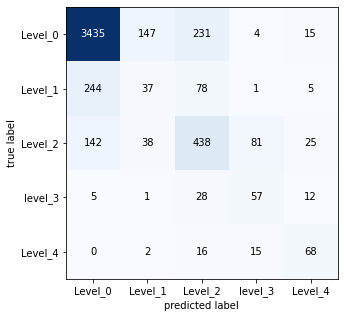

In [17]:
matrix = confusion_matrix (y_val, P3)
plot_confusion_matrix(matrix, figsize=(5,5))
plt.xticks(range(5), ['Level_0','Level_1','Level_2','level_3','Level_4'], fontsize=10)
plt.yticks(range(5), ['Level_0','Level_1','Level_2','level_3','Level_4'], fontsize=10)

In [20]:
tp, fp, tn ,fn = perf_measure(y_val,P3)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F-Score is {:.2f}".format(f_score))

Recall of the model is 0.09
Precision of the model is 0.10
F-Score is 0.09
